The model is overfitting like crazy, but it'll get better once we make our dataset larger.

### Install pytorch 

In [3]:
# use cross entropy for classification problems

import time
import platform
import io

import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.pyplot import cm 

# import KFold from scikit-learn
from sklearn.model_selection import KFold

def install_pytorch():
  os = platform.system()
  if os == "Linux":
      !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
  elif os == "Windows":
      !pip3 install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-win_amd64.whl 
  !pip3 install torchvision


# Install PyTorch.
install_pytorch()


import torch
import torch.nn as nn
import torch.optim as optim

## Dataset

### Import and read the CSV file 

Load the dataset.

In [0]:
#import csv dataset
import torchvision
import csv
import os
import pandas as pd 
from urllib import request
import requests

# Upload and read the csv file from the github repo

df = pd.read_csv("https://raw.githubusercontent.com/HelenG123/aeye-alliance/master/Data/data_day3.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/HelenG123/ai-alliance/master/brailleFinalv2.csv")

#https://raw.githubusercontent.com/HelenG123/ai-alliance/master/braille_data.csv
# # Read the CSV file from a local directory
# dataset_name = list(dataset.keys())[0]
# df = pd.read_csv(io.StringIO(dataset[dataset_name].decode('utf-8')))


### Generate the Targets
Create a dictionary that contains the target number for each image in the Braille alphabet.


In [5]:
# not using one hot encoding vector
# using 1-26 to represent a-z instead

import string

target = {}
alphabet = list(string.ascii_lowercase)

number = 0 
for letter in alphabet: 
  target[letter] = number
  number += 1

print(target)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}


### Iterate over the CSV files to add the targets
Create a dictionary of the images that contains the image as a Tensor and its target as a number between 1-26.

In [7]:
from scipy import misc
from io import BytesIO
import urllib
import cv2
import numpy as np
import tensorflow as tf

import urllib.request

from torchvision import transforms

data=[]

for i, row in df.iterrows():
  picture = []
  url = row['Labeled Data']
  label = row['Label']
  curr_target = target[label[10]]
  # print(curr_target)

  x = urllib.request.urlopen(url)
  resp = x.read()
  image = np.array(bytearray(resp), dtype=np.uint8)
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # resize image to 28x28x3
  image = cv2.resize(image, (28, 28))
  image = image.astype(np.float32)/255.0
   #image = image.flatten().astype(np.float32)/255.0
  image = torch.from_numpy(image)
  picture.append(image)
  curr_target=torch.LongTensor([curr_target])
  picture.append(curr_target)
  data.append(picture)

print(image.shape) # these are the dimensions of our image
# print(data[0][0])
# print(data[0][1])
# print(max([d[1] for d in data]))

data_test=[]

for i, row in df_test.iterrows():
  picture = []
  url = row['Labeled Data']
  label = row['External ID']
  curr_target = target[label[0]]
  # print(curr_target)

  x = urllib.request.urlopen(url)
  resp = x.read()
  image = np.array(bytearray(resp), dtype=np.uint8)
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # resize image to 28x28x3
  image = cv2.resize(image, (28, 28))
  image = image.astype(np.float32)/255.0
   #image = image.flatten().astype(np.float32)/255.0
  image = torch.from_numpy(image)
  picture.append(image)
  curr_target=torch.LongTensor([curr_target])
  picture.append(curr_target)
  data_test.append(picture)

torch.Size([28, 28, 3])


### Create DataLoader objects

Dataloader gives the object that we can iterate over for enumerating and training our data.

In [8]:
# batch sizes for train, test, and validation
batch_size_train = 10
batch_size_test = 5
batch_size_validation = 10

# splitting data to get training and validation sets
train_dataset = data[:600]
validation_dataset = data[601:]

# create the dataloader objects
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size_validation, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size_test, shuffle=False)

print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

60
9
16


### Visualize the Image
Demonstrate that we can access and display an image from the dataset. 


Braille Target: Y/y


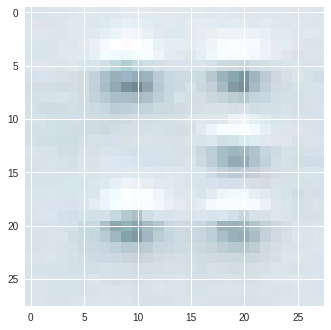

In [9]:
# Display 'y' in Brailles
import matplotlib.pyplot as plt
import numpy as np
dd = data[100][0].numpy()
print('Braille Target: Y/y')
plt.imshow(dd)
plt.show()


## CNN Model

### Define the Model

In [94]:
# import the nn.Module class
import torch.nn as nn

# defines the convolutional neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            #3x28x28
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            #16x28x28
            nn.MaxPool2d(kernel_size=2),
            #16x14x14
            nn.LeakyReLU()
        )
        #16x14x14
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, 
                      out_channels=32, 
                      kernel_size=5, 
                      stride=1, 
                      padding=2),
            #32x14x14
            nn.MaxPool2d(kernel_size=2),
            #32x7x7
            nn.LeakyReLU()
        ) 
        # linearly 
        self.block3 = nn.Sequential(
            nn.Linear(32*7*7, 100),
            nn.LeakyReLU(),
#             nn.Linear(500, 300),
#             nn.Linear(300, 100),
            nn.Linear(100, 26)
        )
        
        #1x26
    
    def forward(self, x): 
        out = self.block1(x)
        out = self.block2(out)
        # flatten the dataset
        out = out.view(-1, 32*7*7)
        out = self.block3(out)
        
        return out

# convolutional neural network model
model = CNN()

# print summary of the neural network model to check if everything is fine. 
print(model)
print("# parameter: ", sum([param.nelement() for param in model.parameters()]))
print(image.shape)

CNN(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): Linear(in_features=1568, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=26, bias=True)
  )
)
# parameter:  173574
torch.Size([28, 28, 3])


### Set the learning rate, criterion, & optimizer

In [0]:
#setting the learning rate
learning_rate = 1e-3

# Using a variable to store the cross entropy method
criterion = nn.CrossEntropyLoss()

# Using a variable to store the optimizer 
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)


## Train and Evaluate the data

### Train the model on the train and evaluation sets

In [105]:
t0 = time.time()

# list of all train_losses in 30 epochs
train_losses = []
# list of all validation losses in 30 epochs
validation_losses = []

# total train losses
total_train_losses = []
# total validation losses
total_validation_losses = []

# for loop that iterates over all the epochs
num_epochs = 40
for epoch in range(num_epochs):
    
  # variables to store/keep track of the loss and number of iterations
  train_loss = 0
  num_iter_train = 0

  # train the model
  model.train()
    
  # Iterate over train_loader
  for i, (images, labels) in enumerate(train_loader):  
    # need to permute so that the images are of size 3x28x28 
    # essential to be able to feed images into the model
    images = images.permute(0, 3, 1, 2)

    # Zero the gradient buffer
    # resets the gradient after each epoch so that the gradients don't add up
    optimizer.zero_grad()  

    # Forward
    outputs = model(images)

    # calculate the loss
    loss = criterion(outputs, labels.view(-1))
    #print('loss:', loss)
    total_train_losses.append(loss)
    # Backward (computes all the gradients)
    loss.backward()

    # Optimize
    # loops through all parameters and updates weights by using the gradients 
    # takes steps backwards to optimize (to reach the minimum weight)
    optimizer.step()
    # update the training loss and number of iterations
    train_loss += loss.data[0]
    num_iter_train += 1

  print('Epoch: {}, Training Loss: {:.4f}'.format(
        epoch+1, train_loss/num_iter_train))
  
  train_losses.append(train_loss/num_iter_train)
    
  # variables to store/keep track of the loss and number of iterations
  validation_loss = 0
  num_iter_validation = 0
    
  # Iterate over train_loader
  for i, (images, labels) in enumerate(validation_loader):  
    # need to permute so that the images are of size 3x28x28 
    # essential to be able to feed images into the model
    images = images.permute(0, 3, 1, 2)
    # print(images.shape)

    # Zero the gradient buffer
    # resets the gradient after each epoch so that the gradients don't add up
    optimizer.zero_grad()  

    # Forward
    outputs = model(images)

    # calculate the loss
    loss = criterion(outputs, labels.view(-1))
    #print('loss:', loss)
    total_validation_losses.append(loss)

    # update the training loss and number of iterations
    validation_loss += loss.data[0]
    num_iter_validation += 1

  print('          Validation Loss: {:.4f}'.format(validation_loss/num_iter_validation))
  
  validation_losses.append(validation_loss/num_iter_validation)

# calculate time it took to train the model
tf = time.time()
print()
print("time: {} s" .format(tf-t0))

# print training loss and validation loss for all 30 epochs
print(train_losses)
print(validation_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Training Loss: 0.0049
          Validation Loss: 1.7617


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 2, Training Loss: 0.0048
          Validation Loss: 1.7622
Epoch: 3, Training Loss: 0.0048
          Validation Loss: 1.1488
Epoch: 4, Training Loss: 0.0032
          Validation Loss: 1.7977
Epoch: 5, Training Loss: 0.0042
          Validation Loss: 1.0837
Epoch: 6, Training Loss: 0.0040
          Validation Loss: 1.0937
Epoch: 7, Training Loss: 0.0047
          Validation Loss: 1.0990
Epoch: 8, Training Loss: 0.0045
          Validation Loss: 1.0923
Epoch: 9, Training Loss: 0.0034
          Validation Loss: 1.1454
Epoch: 10, Training Loss: 0.0043
          Validation Loss: 1.3967
Epoch: 11, Training Loss: 0.0044
          Validation Loss: 1.1233
Epoch: 12, Training Loss: 0.0043
          Validation Loss: 1.8568
Epoch: 13, Training Loss: 0.0033
          Validation Loss: 1.1342
Epoch: 14, Training Loss: 0.0048
          Validation Loss: 1.0906
Epoch: 15, Training Loss: 0.0056
          Validation Loss: 1.0992
Epoch: 16, Training Loss: 0.0046
          Validation Loss: 1.1557
Epo

### Plot the learning curve

The learning curve is the validation & train losses over the training steps. Need to plot the learning curve to check for overfitting. 

In [0]:
# learning curve function
def plot_learning_curve(train_losses, validation_losses):
  # plot the training and validation losses
  # x-axis is the number of training steps
  # y-axis is loss
  plt.ylabel('Loss')
  plt.xlabel('Number of Epochs')
  plt.plot(train_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

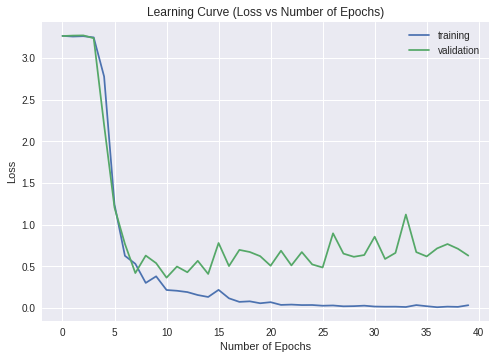

In [98]:
# plot
plt.title("Learning Curve (Loss vs Number of Epochs)")
plot_learning_curve(train_losses, validation_losses)

### Evalutate the model

Don't touch the test set until the very end. 

In [99]:
t0 = time.time()

# for loop that iterates over all the epochs
num_epochs = 30
for epoch in range(num_epochs):

  # evaluate the model
  model.eval()

  correct = 0
  total = 0

  # Iterate over test_loader
  for images, labels in test_loader:  

     # need to permute so that the images are of size 3x28x28 
     # essential to be able to feed images into the model
     images = images.permute(0, 3, 1, 2)

     # Forward
     outputs = model(images)
     loss = criterion(outputs, labels.view(-1))
     # torch.max returns the max value, as well as the index of that max value
     _, predicted = torch.max(outputs.data, 1)

     # Statistics
     total += labels.size(0)
     correct += (predicted == labels).sum()

  print('Epoch {}, Accuracy on the test set: {}%'.format(epoch+1, 100 * correct / total))

tf = time.time()
print()
print("time: {} s" .format(tf-t0))

Epoch 1, Accuracy on the test set: 100%
Epoch 2, Accuracy on the test set: 100%
Epoch 3, Accuracy on the test set: 100%
Epoch 4, Accuracy on the test set: 100%
Epoch 5, Accuracy on the test set: 100%
Epoch 6, Accuracy on the test set: 100%
Epoch 7, Accuracy on the test set: 100%
Epoch 8, Accuracy on the test set: 100%
Epoch 9, Accuracy on the test set: 100%
Epoch 10, Accuracy on the test set: 100%
Epoch 11, Accuracy on the test set: 100%
Epoch 12, Accuracy on the test set: 100%
Epoch 13, Accuracy on the test set: 100%
Epoch 14, Accuracy on the test set: 100%
Epoch 15, Accuracy on the test set: 100%
Epoch 16, Accuracy on the test set: 100%
Epoch 17, Accuracy on the test set: 100%
Epoch 18, Accuracy on the test set: 100%
Epoch 19, Accuracy on the test set: 100%
Epoch 20, Accuracy on the test set: 100%
Epoch 21, Accuracy on the test set: 100%
Epoch 22, Accuracy on the test set: 100%
Epoch 23, Accuracy on the test set: 100%
Epoch 24, Accuracy on the test set: 100%
Epoch 25, Accuracy on the